# Problem 5.2: Covid-19 tests - data reader

The following is a small program to read the data file "data_Covid19tests.txt", which contains three column: Date (in January 2021), Number of (PCR) tests on that day, and number of positive tests that day.

### Author & Date: 
- Troels C. Petersen (Niels Bohr Institute)
- 07-11-2021

***

In [1]:
# Read the data and print it to check it:
import numpy as np
import matplotlib.pyplot as plt

from ExternalFunctions import Chi2Regression

from scipy import stats
from iminuit import Minuit

In [2]:
date, Ntests, Npositives = np.loadtxt("data_Covid19tests.txt", skiprows=2, unpack=True)

print("Number of entries: ", len(date))
for i in range(len(date)) : 
    print(f"  {date[i]:2.0f}  {Ntests[i]:6.0f}  {Npositives[i]:5.0f}")

Number of entries:  15
   4  103270   2464
   5  102145   1920
   6   93981   1647
   7   83748   1573
   8   73944   1428
   9   51387   1192
  10   47092    989
  11   79306   1340
  12   83126   1238
  13   76080   1112
  14  103694    998
  15   97416    844
  16   75592    719
  17   73613    670
  18  101957    882


In [3]:
def calculate_weighted_mean(data, uncertainties):
    return np.sum(data/uncertainties**2)/np.sum(1./uncertainties**2)

def calculate_uncertainty(uncertainties):
    return np.sqrt(1./np.sum(1./uncertainties**2))

83090.06666666667


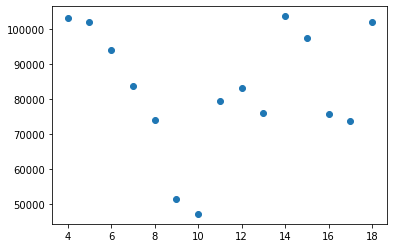

In [4]:
mean_Ntests = np.sum(Ntests)/len(Ntests)
mean_Npositives = np.sum(Npositives)/len(Npositives)
print(mean_Ntests)
plt.scatter(date,Ntests)
plt.show()

In [5]:
scaled_positives = Npositives * (Ntests/mean_Ntests)**(-0.7)

In [35]:
def SP_func_1(t, SP0, R, t0):
    tG=4.7
    return SP0 * R**((t-t0)/tG)

def do_a_chi2_fit(x_data, y_data, sigma_y_data, f, init_guess):
    """Does a chi2 fit, plots results and returns the minuit output
    init_guess needs to have the initial fit parameters in a list format (e.g. [a,b,c])"""
    chi2 = Chi2Regression(f, x_data, y_data, sigma_y_data)
    chi2.errordef = 1
    minuit_chi2 = Minuit(chi2, *init_guess) #   
    display(minuit_chi2.migrad())          # Perform the actual fit

    # Get number of degrees-of-freedom (Ndof):
    Ndof_value = len(x_data) - minuit_chi2.nfit

    chi2_value = minuit_chi2.fval
    p_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
    print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {p_value:5.10f}")

    return minuit_chi2, Ndof_value, p_value

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 21.02                      │              Nfcn = 84               │
│ EDM = 6.77e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ SP0  │   3.2e3   │   1.0e3   │            │            │         │         │       │
│ 1 │ R    │   0.723   │   0.020   │            │            │         │         │       │
│ 2 │ t0   │    -3     │     5     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬───────────────────────────────┐
│     │       SP0         R        t0 │
├─────┼───────────────────────────────┤
│ SP0 │  9.91e+05     -2.05 -4.37e+03 │
│   R │     -2.05   0.00039  -0.00986 │
│  t0 │ -4.37e+03  -0.00986      20.3 │
└─────┴───────────────────────────────┘

Chi2 value: 21.0   Ndof = 12    Prob(Chi2,Ndof) = 0.0500377832


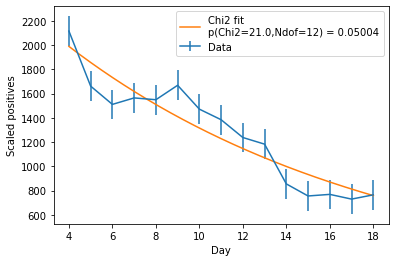

In [51]:
# Do a chi2 fit
forced_sigma_SP = 122.3
minuit_chi2, Ndof_value, p_value = do_a_chi2_fit(date, scaled_positives, forced_sigma_SP, SP_func_1, [10000, 0.5, 0])

# Plot
x_axis = np.linspace(np.min(date), np.max(date), 1000)
y_axis = SP_func_1(x_axis,*minuit_chi2.values)

fig2, ax2 = plt.subplots()
ax2.errorbar(date, scaled_positives, yerr=forced_sigma_SP, label='Data')
ax2.plot(x_axis, y_axis,label=f'Chi2 fit\np(Chi2={minuit_chi2.fval:.1f},Ndof={Ndof_value:d}) = {p_value:.5f}')

ax2.set_xlabel(r'Day')
ax2.set_ylabel(r'Scaled positives')

#ax2.set_xscale('log')
#ax2.set_yscale('log')

ax2.legend()

plt.show()